In [304]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from control.matlab import *
from numba import float32, float64, jit, NumbaPerformanceWarning
import warnings

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [305]:
Ts = 0.1; Fs = 1/Ts

In [306]:
s = tf('s')
m1 = 1
m2 = 0.5
c1 = 0.2
c2 = 0.5
k1 = 1
k2 = 0.5

In [307]:
P = ( m1*s**2 + (c1+c2)*s + (k1+k2) ) / ( (m1*s**2 + (c1+c2)*s + k1+k2)*(m2*s**2+c2*s+k2) - (k2+c2*s)**2 )

In [308]:
T = 50
t = np.arange(0, T, Ts)
u = np.random.normal(0, 10, t.shape)
# T_u = 50 # s
# u = np.zeros(t.shape)
# u[(t >= 0*T_u/2) & (t < 1*T_u/2)] = 1
# u[(t >= 2*T_u/2) & (t < 3*T_u/2)] = 1
# u[(t >= 4*T_u/2) & (t < 5*T_u/2)] = 1
# u[(t >= 6*T_u/2) & (t < 7*T_u/2)] = 1

/home/rbusetto/.conda/envs/transformers-control/lib/python3.10/site-packages/control/timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

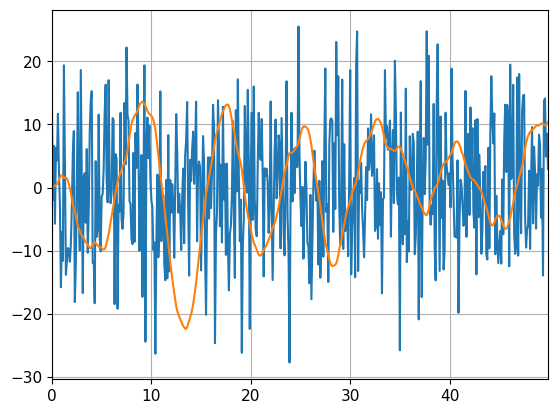

In [309]:
y, _, _ = lsim(P, u, t)
plt.plot(t, u)
plt.plot(t, y)

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

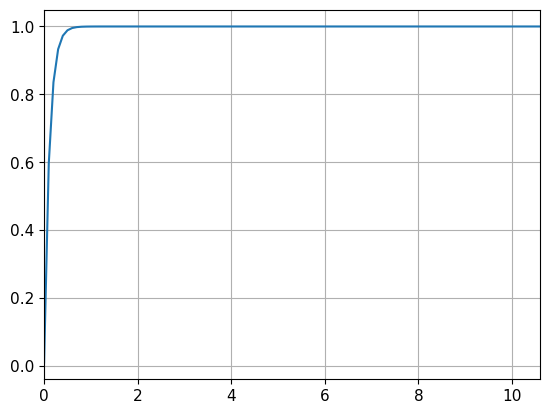

In [310]:
# VRFT
s = tf('s')
tau = 0.7 # s
M = 1/(1 + (tau/(2*np.pi))*s)
M = M*(1 + 1e-2*(tau/(2*np.pi))*s) # add a high freq zero for inversion
T_cl = tau + 10
t_cl = np.arange(0, T_cl, Ts)
y_d, _ = step(M, t_cl)
plt.plot(t_cl, y_d)

In [311]:
# vrft
r_v = lsim(M**(-1), y, t)[0]
e_v = r_v - y

In [312]:
B=[tf([1],[1],Ts),
   tf(Ts*np.array([1, 1]),2*np.array([1, -1]),Ts),
   tf(np.array([2, -2]),Ts*np.array([3, -1]),Ts)]

In [313]:
import cvxpy as cp
theta = cp.Variable(3)
u_theta = theta[0]*lsim(B[0], e_v, t)[0] + theta[1]*lsim(B[1], e_v, t)[0] + theta[2]*lsim(B[2], e_v, t)[0]

In [314]:
cost = cp.sum_squares(u - u_theta)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()
theta_sol = theta.value

In [315]:
C = theta_sol[0]*B[0] + theta_sol[1]*B[1]

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

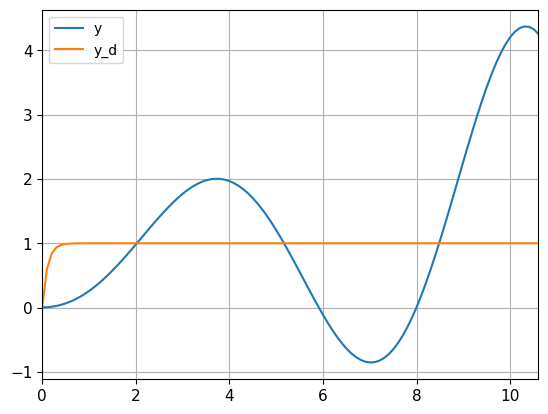

In [316]:
P = c2d(P, Ts, 'tustin')
F = C*P/(1 + C*P)
y_cl, _ = step(F, t_cl, X0=0.0)
plt.plot(t_cl, y_cl, label='y')
plt.plot(t_cl, y_d, label='y_d')
plt.legend()
plt.show()